## Init

In [196]:
import numpy as np
import os.path
import sys
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
from tqdm import tqdm
import datetime
import json
import classifim.bench.metric
import classifim.datasets
import classifim.twelve_sites_pipeline
import classifim.utils
import classifim.data_loading
import classifim.layers
import classifim.pipeline
import concurrent.futures
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import datasets
import my.utils as myu

config_device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Cuda is" + ("" if torch.cuda.is_available() else " NOT") + f" available; setting config_device = '{config_device}'.")

# Pick a directory where to save models and FIM:
DATA_DIR0 = classifim.utils.find_data_dir()
SM_NAME = "kitaev_20" # Name of the statistical manifold
DATA_DIR = os.path.join(DATA_DIR0, SM_NAME)
PARAMETER_GRID = [(-3.9998, 3.9998, 20000)]

Cuda is available; setting config_device = 'cuda:0'.


## Example: getting the dataset

In [232]:
d_train = classifim.datasets.dataset_huggingface_to_dict(datasets.load_dataset(
    'fiktor/FIM-Estimation',
    'kitaev_20.seed00', split='train'))

In [233]:
d_train

{'seed': 0,
 'lambdas': array([[-3.9998],
        [-3.9998],
        [-3.9998],
        ...,
        [ 3.9998],
        [ 3.9998],
        [ 3.9998]], dtype=float32),
 'samples': array([     12,       0,       0, ..., 1048575, 1048527, 1048575],
       dtype=int32)}

## ClassiFIM

### Pipeline class

In [4]:
class DataLoader(classifim.data_loading.InMemoryLoader):
    def _init_zs(self, data, device, chain_length):
        zs = data["zs"][:, None, :]
        assert len(zs.shape) == 3
        self.zs = torch.from_numpy(zs).to(
            device=device, dtype=torch.float32)

    def _retrieve_zs(self, ii):
        return (self.zs[ii], )
    
class Model1DDihedral(nn.Module):
    """
    Model for linear systems with Dihedral symmetry
    """
    def __init__(self, n_sites=20, lambda_coeff=1.0, dlambda_coeff=1.0):
        super().__init__()
        self.n_sites = n_sites
        self.lambda_coeff = lambda_coeff
        self.dlambda_coeff2 = dlambda_coeff**2
        # Other values are not supported for now:
        num_lambdas = 1

        # Process lambdas and dlambdas**2.
        self.lambdas_fc = nn.Sequential(
            nn.Linear(num_lambdas * (num_lambdas + 3) // 2, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU()
        )
        
        conv = classifim.layers.Conv1DDihedral
        # Process zs
        self.zs_cnn = nn.Sequential(
            conv(1, 32, kernel_size=4),
            nn.ReLU(),
            conv(32, 64, kernel_size=4),
            nn.ReLU()
        )

        # Final classification
        self.fc = nn.Sequential(
            nn.Linear(64 + 64, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_lambdas)
        )

    def forward(self, lambdas, dlambdas, zs):
        """
        Args:
            lambdas: tensor of shape (*batch_size, 2).
            dlambdas: tensor of shape (*batch_size, 2).
            zs: tensor of shape (*batch_size, n_sites, 2).

        Returns:
            output1: tensor of shape (*batch_size, 2).
                Represents the output of NN before sigmoid.
                The purpose of the model is to make this output available.
            output2: tensor of shape (*batch_size,).
                Represents the final output of NN.
                This output is used for cross-entropy loss.
        """
        batch_size = dlambdas.shape[:-1]
        assert lambdas.shape[-1] == 1
        lambdas_in = torch.cat([
                self.dlambda_coeff2 * (dlambdas[..., 0, np.newaxis]**2 - 2/3),
                self.lambda_coeff * lambdas
            ], dim=-1)

        # Process lambdas
        lambdas_out = self.lambdas_fc(lambdas_in)

        # Process zs
        assert zs.shape == (*batch_size, 1, self.n_sites), f"{zs.shape} != {(*batch_size, 1, self.n_sites)}"
        zs_out = self.zs_cnn(zs)
        assert zs_out.shape == (*batch_size, 64, self.n_sites), f"{zs_out.shape} != {(*batch_size, 64, self.n_sites)}"
        zs_out = F.adaptive_avg_pool1d(zs_out, 1).squeeze(dim=-1)
        assert zs_out.shape == (*batch_size, 64), f"{zs_out.shape} != {(*batch_size, 64)}"

        # Concatenate
        combined = torch.cat([lambdas_out, zs_out], dim=1)

        # Final classification
        output1 = self.fc(combined)
        assert output1.shape == dlambdas.shape
        output2 = torch.sum(output1 * dlambdas, dim=-1)
        assert output2.shape == (*batch_size,)

        return output1, output2

class Pipeline(classifim.pipeline.Pipeline):
    """
    Pipeline for Kitaev20.
    """
    def unpack_zs(self, packed_zs):
        chain_length = self.config["chain_length"]
        zs_bin = classifim.utils.unpackbits(packed_zs, chain_length)
        return 1 - 2 * zs_bin

    def fill_zs(self, dataset):
        dataset["zs"] = self.unpack_zs(dataset["packed_zs"])
    
    def fit_transform(self, dataset):
        self.fit_transform_lambdas(dataset)
        if "chain_length" not in self.config:
            if "chain_length" in dataset:
                self.config["chain_length"] = dataset["chain_length"]
            else:
                guess = int(0.5 + np.log2(1 + np.max(dataset["packed_zs"])))
                self.config["chain_length"] = guess
        self.fill_zs(dataset)
                
    def transform(self, dataset):
        self.transform_lambdas(dataset)
        self.fill_zs(dataset)
        
    def _get_data_loader(self, dataset, is_train, batch_size=None, device=None):
        """
        Construct a DataLoader for the training or test set.

        Note that the returned object is not torch.utils.data.DataLoader
        for efficiency reasons.
        """
        if device is None:
            device = self.config["device"]
        if batch_size is None:
            batch_size = self.config.get("batch_size", 2**14)
        return DataLoader(
            dataset, batch_size=batch_size, device=device,
            chain_length=self.config["chain_length"],
            subsample=self.config.get("subsample", None))

    def construct_model(self, device=None):
        model_init_kwargs = self.config.get("model_init_kwargs", {})
        model = Model1DDihedral(**model_init_kwargs)
        if device is not None:
            model = model.to(device)
        self.model = model

    def get_fim_loader(self, dataset, batch_size=None, device=None):
        """
        Returns a generator that yields batches of data for FIM estimation.
        """
        if device is None:
            device = self.config["device"]
        if batch_size is None:
            batch_size = self.config.get("batch_size", 2**14)
        zs = torch.from_numpy(dataset["zs"][:, None, :]).to(
            device=device, dtype=torch.float32)
        num_samples = zs.shape[0]
        num_batches = int(np.ceil(num_samples / batch_size))
        for i in range(num_batches):
            batch_start = i * batch_size
            batch_end = min((i + 1) * batch_size, num_samples)
            yield (
                slice(batch_start, batch_end),
                (zs[batch_start:batch_end],))

In [5]:
if "training_log" not in globals():
    training_log = {}

def preprocess_for_json(log):
    if isinstance(log, dict):
        return {str(key): preprocess_for_json(value) for key, value in log.items()}
    return log

def save_training_log(log, filename):
    with open(filename, 'w') as f:
        json.dump(preprocess_for_json(log), f, default=str)
        
def load_training_log(filename):
    with open(filename, 'r') as f:
        return json.load(f)

### Run pipeline

In [14]:
dataset_name = "Kitaev20"
data_dir = os.path.join(DATA_DIR0, dataset_name.lower())
datasets_dir = os.path.join(data_dir, "classifim_datasets")
models_dir = classifim.utils.maybe_create_subdir(data_dir, "models")
chifc_dir = classifim.utils.maybe_create_subdir(data_dir, "fim")

for dataset_i in range(10):
    t0 = time.time()
    cur_log = {}
    suffix = f"42_{dataset_i}"
    config = {
        "dataset_filename": os.path.join(datasets_dir, f"dataset_{suffix}.npz"),
        "model_filename": os.path.join(models_dir, f"9_reshuffle_{suffix}.pth"),
        "fim_filename": os.path.join(chifc_dir, f"9_reshuffle_{suffix}.npz"),
        "test_dump_filename": os.path.join(datasets_dir, f"test_dump_{suffix}.npz"),
        "num_epochs": 319,
        "suffix": suffix,
        "seed": suffix,
        "max_lr": 2e-3,
        "device": config_device,
        "subsample": int(0.5 + 64**2 * 140 * 0.9),
        "model_init_kwargs": {"lambda_coeff": 3, "dlambda_coeff": 1},
        "hold_out_test": True,
        "scalar_keys": [
            "seed", "dataset_i", "num_datasets", "fermft_seed", "param.t",
            "param.delta"]
    }
    print(f"{datetime.datetime.now()}: {suffix} {config['model_init_kwargs']}")
    cur_log["config"] = config
    pipeline = Pipeline(config=config)
    print(f"{datetime.datetime.now()}: Train")
    t1 = time.time()
    cur_log["train"] = pipeline.train()
    t2 = time.time()
    print(f"{datetime.datetime.now()}: Save")
    pipeline.save_model()
    pipeline.cleanup_after_training()
    pipeline.load_model()
    t3 = time.time()
    cur_log["test"] = pipeline.test()
    t4 = time.time()
    pipeline.eval_fim()
    pipeline.save_fim()
    t5 = time.time()
    dtrun = t5 - t0
    dttest = t4 - t3
    cur_log["timings"] = {"dtrun": dtrun, "dtrun_only": dtrun - dttest, "dttrain": t2 - t1}
    training_log[suffix] = training_log.get(suffix, [])
    training_log[suffix].append(cur_log)
    print("Timings: " + ", ".join(f"{key}: {value:.3f}s" for key, value in cur_log["timings"].items()))

LOG_FILENAME = f"{data_dir}/training_log.json"
save_training_log(
    training_log,
    filename=LOG_FILENAME)

2023-09-25 10:44:54.719472: 42_0 {'lambda_coeff': 3, 'dlambda_coeff': 1}
2023-09-25 10:44:55.234382: Train
2023-09-25 10:44:55.355557: Training started
num_epochs=319: 1:0.6557 2:0.5588 3:0.4551 4:0.3857 5:0.3077 6:0.2601 7:0.2482 8:0.244 9:0.2411 10:0.2392 11:0.2379 12:0.2361 13:0.2349 14:0.2336 15:0.2326 16:0.2315 17:0.2308 18:0.23 19:0.2295 20:0.2281 21:0.2285 22:0.2272 23:0.2267 24:0.2258 25:0.2253 26:0.2253 27:0.2252 28:0.2248 29:0.2246 30:0.224 31:0.2237 32:0.2236 33:0.2221 34:0.2219 35:0.2222 36:0.2212 37:0.222 38:0.221 39:0.2214 40:0.2209 41:0.2206 42:0.2205 43:0.2193 44:0.2195 45:0.2202 46:0.2188 47:0.2196 48:0.2189 49:0.2185 50:0.219 51:0.22 52:0.2191 53:0.2189 54:0.2185 55:0.2168 56:0.2179 57:0.2174 58:0.2178 59:0.2169 60:0.2171 61:0.2166 62:0.2165 63:0.217 64:0.2167 65:0.2154 66:0.2167 67:0.2166 68:0.2169 69:0.2156 70:0.217 71:0.2163 72:0.2159 73:0.2156 74:0.2162 75:0.2149 76:0.2145 77:0.2152 78:0.2152 79:0.2158 80:0.2149 81:0.2146 82:0.2149 83:0.2151 84:0.2158 85:0.2143 86

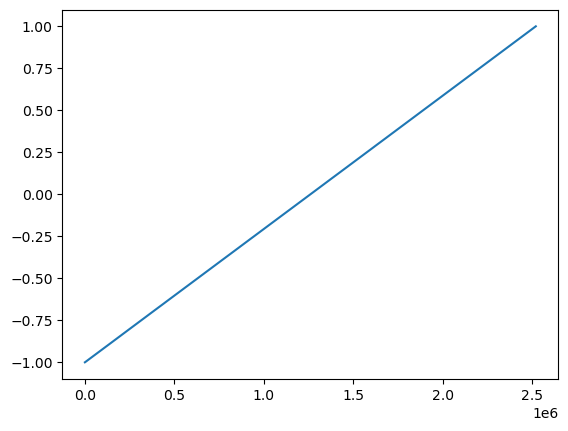

In [12]:
import matplotlib.pyplot as plt
plt.plot(pipeline.dataset_train['scaled_lambdas'])

## Van Nieuwenburg's W

In [228]:
importlib.reload(classifim.io)
importlib.reload(classifim.pipeline)
importlib.reload(classifim.w)

def gen_wconfig(**kwargs):
    config = {
        "n_sites": 12,
        "num_epochs": 6,
        "one_cycle_lr.num_epochs": 7,
        "batch_size": 2**8,
        "max_lr": 5e-3,
        "hold_out_test": True,
        "test_fraction": 0.5,
        "one_cycle_lr.pct_start": 0.0,
        "scalar_keys": set(["seed"]),
        "model_name": "w",
        # TODO: subsample?
        "device": config_device}    
    config.update(kwargs)
    classifim.w.config_set_default_filenames(
        config,
        models_dir=os.path.join(DATA_DIR0, config["sm_name"], "models"))
    return config

In [229]:
import classifim.w
class WPipeline(classifim.w.Pipeline):
    pass

In [231]:
for seed, sweep_lambda_index in itertools.product(range(10), range(2)):
    classifim.w.run_pipeline(
        sm_name=SM_NAME,
        gen_config_f=gen_wconfig,
        gen_pipeline_f=WPipeline,
        seed=seed, sweep_lambda_index=sweep_lambda_index, skip_existing=False)

2024-05-19 10:14:56.802609: w_0
Computing /media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/kitaev_20/models/w_00_0.w.npz


AssertionError: 

## Benchmarking

### Load FIM

In [25]:
importlib.reload(classifim.bench.fidelity)
gt_fim = classifim.datasets.load_gt_fim(sm_name=SM_NAME)
assert isinstance(gt_fim, pd.DataFrame)
print(f"Loaded gt_fim")

ML_NAME = "9_reshuffle_42"
FIM_DIR = os.path.join(DATA_DIR, "fim")
ml_fims = classifim.bench.fidelity.read_ml_fims(
    FIM_DIR, rf'^{ML_NAME}_\d+$',
    ignore_prefix=f'{ML_NAME}_', key_dtype=int)
assert isinstance(ml_fims, dict)
print(f"Loaded ml_fims for keys {sorted(ml_fims.keys())}")

Loaded gt_fim
Loaded ml_fims for keys [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


### FIM of spectrum

Max(FIM / 20): 4707.0 @ mu = -2.0000
Saved to /media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/kitaev_20/figs/kitaev20-spectrum-fim.png


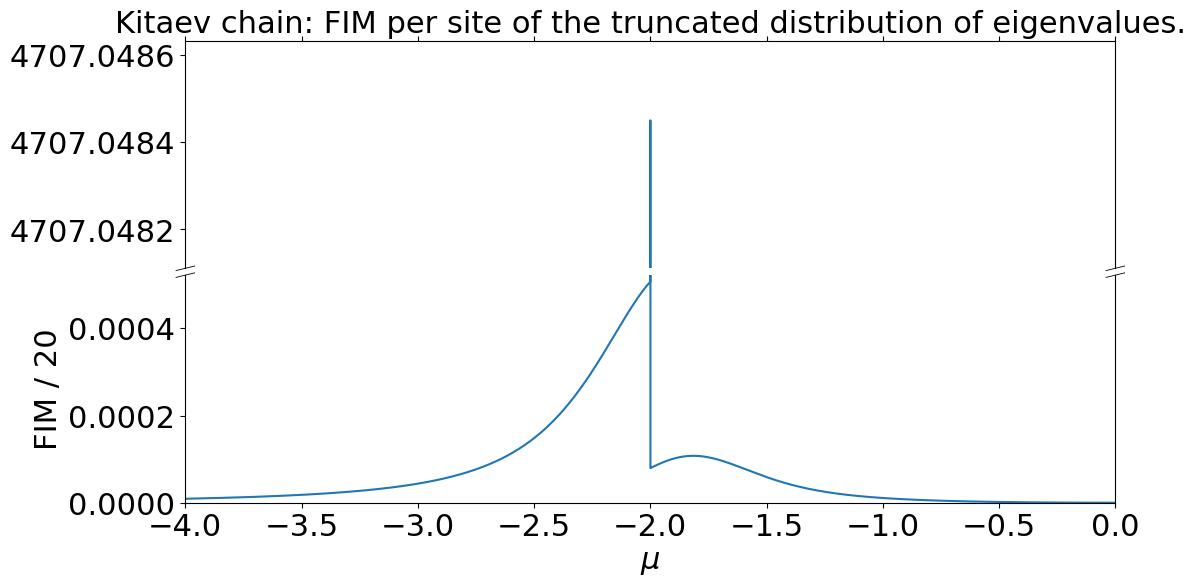

In [28]:
SMALLEST_SIZE = 16
SMALL_SIZE = 17
MEDIUM_SIZE = 22
BIGGER_SIZE = 30

matplotlib.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
matplotlib.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=SMALLEST_SIZE)    # legend fontsize
matplotlib.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
fig.subplots_adjust(hspace=0.03)
chain_length = 20
mu_range_len = np.max(gt_fim['lambda0']) - np.min(gt_fim['lambda0'])
scaled_fim = gt_fim['fim_10'] / (chain_length * mu_range_len**2)
for ax in axs:
    ax.plot(gt_fim['lambda0'], scaled_fim)

y_height = np.sort(scaled_fim)[-3] * 1.03
y_topf = 0.35
ymax = np.max(scaled_fim)

axs[0].ticklabel_format(useOffset=False)
axs[0].set_ylim((ymax - y_height * (1 - y_topf), ymax + y_height * y_topf))
axs[1].set_ylabel(f"FIM / {chain_length}")
axs[1].set_xlim((-4, 0))
axs[1].set_xlabel("$\mu$")
axs[1].set_ylim((0, y_height))

axs[0].spines['bottom'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[0].xaxis.tick_top()

d = .01 # how big to make the diagonal lines in axes coordinates

for yi, ax in enumerate(axs):
    for x_offset in (0, 1):
        ax.plot((x_offset - d, x_offset + d), (yi - d, yi + d),
                transform=ax.transAxes, color='k', clip_on=False,
                linewidth=0.6)

axs[0].set_title(f"Kitaev chain: FIM per site of the truncated distribution of eigenvalues.")

print(f"Max(FIM / {chain_length}): {ymax:.1f} @ mu = {gt_fim['lambda0'][np.argmax(scaled_fim)]:.4f}")
filename = f"{DATA_DIR}/figs/kitaev20-spectrum-fim.png"
fig.savefig(filename, bbox_inches='tight', dpi=300)
print(f"Saved to {filename}")

### Plot FIM

Max($\chi_F$ / 20): 39070.3 @ mu = 2.0052


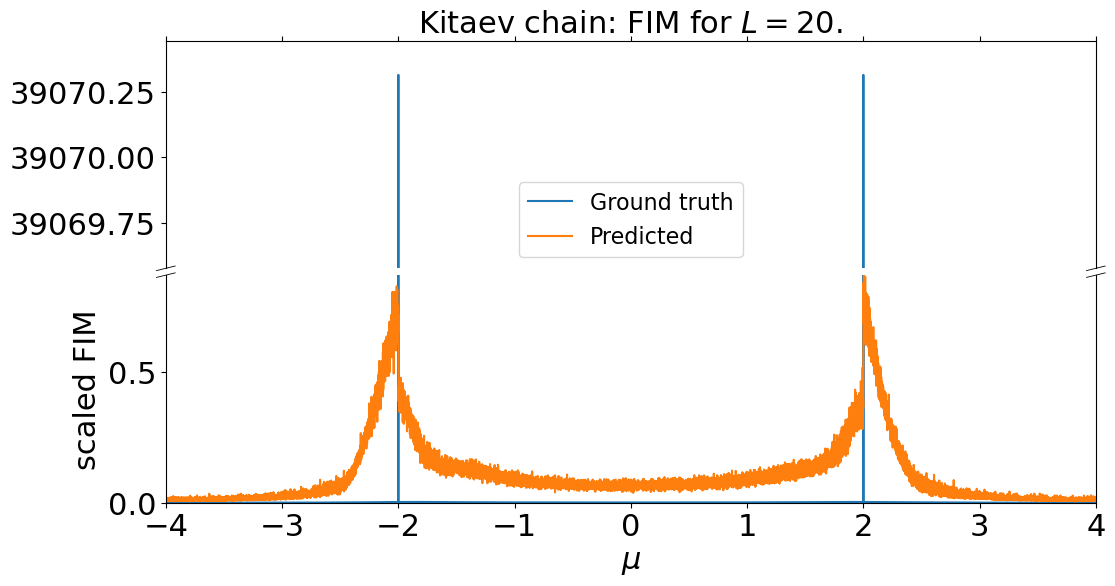

In [30]:
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
fig.subplots_adjust(hspace=0.03)
seed = 0

chain_length = 20
mu_range_len = np.max(gt_fim['lambda0']) - np.min(gt_fim['lambda0'])
scaled_fim_hat = ml_fims[seed]["fim_00"] / (chain_length * mu_range_len**2)
scaled_fim_gs = gt_fim['fim'] / (chain_length * mu_range_len**2)
ml_mus = np.array(ml_fims[seed]["lambda0"]) * mu_range_len + np.min(gt_fim['lambda0'])
for ax in axs:
    ax.plot(gt_fim['lambda0'], scaled_fim_gs, label="Ground truth")
    ax.plot(ml_mus, scaled_fim_hat, label="Predicted")

y_height = np.sort(scaled_fim_hat)[-3] * 1.03
y_topf = 0.15
ymax = np.max(scaled_fim_gs)

axs[0].ticklabel_format(useOffset=False)
axs[0].set_ylim((ymax - y_height * (1 - y_topf), ymax + y_height * y_topf))
axs[0].legend()
axs[1].set_ylabel("scaled FIM")
axs[1].set_xlim((-4, 4))
axs[1].set_xlabel("$\mu$")
axs[1].set_ylim((0, y_height))

axs[0].spines['bottom'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[0].xaxis.tick_top()

d = .01 # how big to make the diagonal lines in axes coordinates

for yi, ax in enumerate(axs):
    for x_offset in (0, 1):
        ax.plot((x_offset - d, x_offset + d), (yi - d, yi + d),
                transform=ax.transAxes, color='k', clip_on=False,
                linewidth=0.6)

axs[0].set_title(f"Kitaev chain: FIM for $L=20$.")

print(f"Max($\chi_F$ / {chain_length}): {ymax:.1f} @ mu = {gt_fim['lambda0'][np.argmax(scaled_fim_hat)]:.4f}")
# filename = f"{DATA_DIR}/figs/kitaev20-spectrum-chif.png"
# fig.savefig(filename, bbox_inches='tight', dpi=300)
# print(f"Saved to {filename}")

### Inset

Text(0.5, 1.0, 'Kitaev chain: FIM per fermion for $L=20$.')

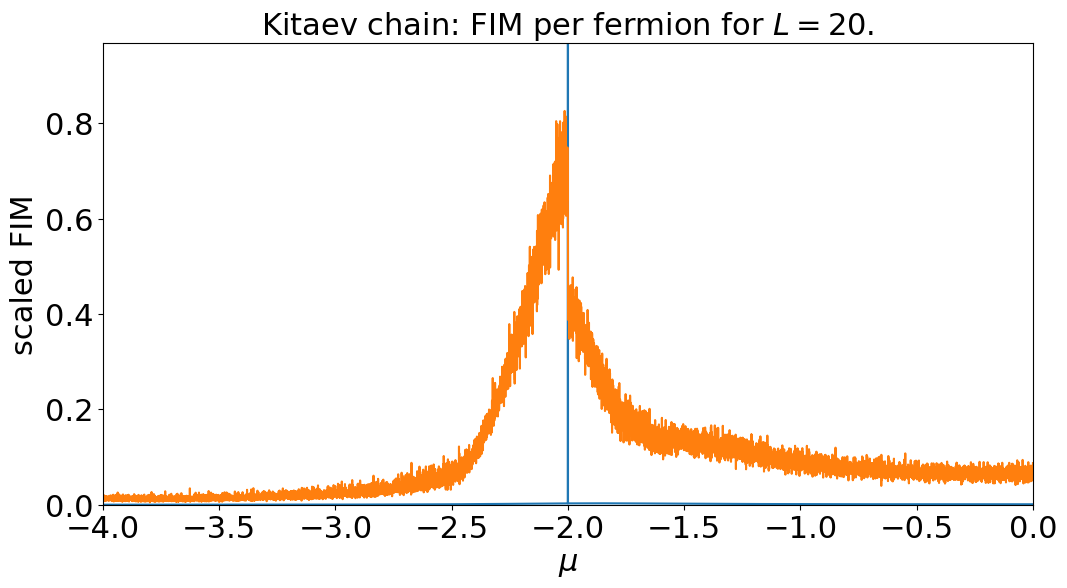

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(gt_fim['lambda0'], scaled_fim_gs, label="Ground truth")
ax.plot(ml_mus, scaled_fim_hat, label="Predicted")
ax.set_xlim([-4, 0])
ax.set_ylim([0, 1.1 * np.max(scaled_fim_hat)])

ax.set_ylabel("scaled FIM")
ax.set_xlim((-4, 0))
ax.set_xlabel("$\mu$")
ax.set_title(f"Kitaev chain: FIM per fermion for $L=20$.")

(-4.0, 0.0)

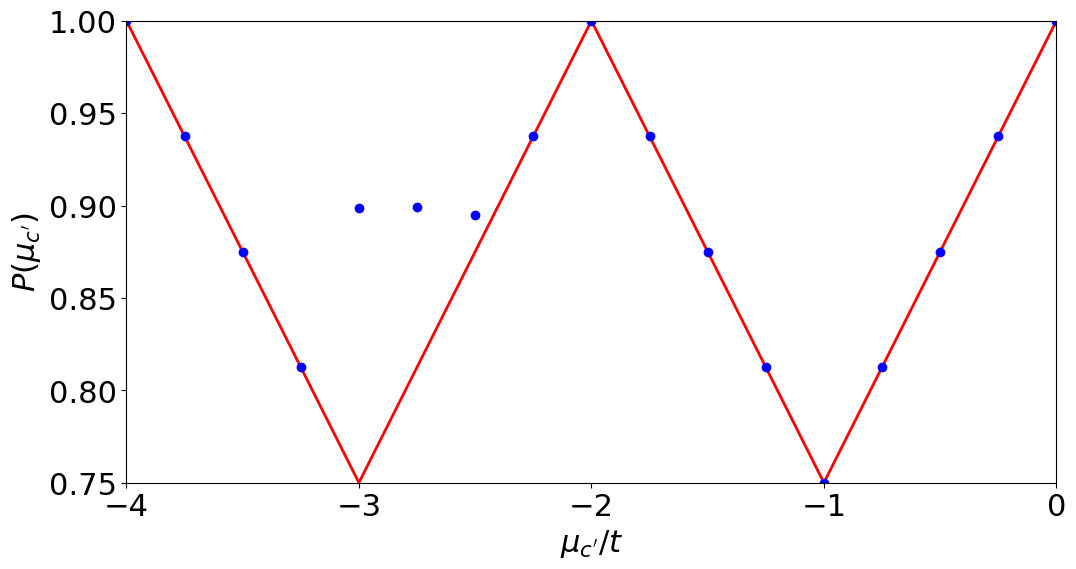

In [32]:
w_learned_x=[-4.0, -3.75, -3.5, -3.25, -3.0, -2.75, -2.5, \
   -2.25, -2.0, -1.75, -1.5, -1.25, -1.0, -0.75, -0.5, -0.25, 0.0]
w_learned_y=[1.0, 0.9375, 0.875, 0.8125, 0.8987, 0.8994, \
   0.8947, 0.9376, 1.0, 0.9376, 0.8751, 0.8126, 0.75, 0.8125, 0.875, 0.9375, 1.0]
w_perfect_x = [-4,-3,-2,-1,0]
w_perfect_y = [1,0.75,1,0.75,1]

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(w_perfect_x, w_perfect_y, '-r', lw=2)
ax.plot(w_learned_x, w_learned_y, 'bo')
ax.set_xlabel('$\mu_{c\'}/t$')
ax.set_ylabel('$P(\mu_{c\'})$')
ax.set_ylim([0.75,1.])
ax.set_xticks([-4,-3,-2,-1,0])
ax.set_xlim((-4, 0))

Saved to /media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/kitaev_20/figs/kitaev20-w-fim-inset.png


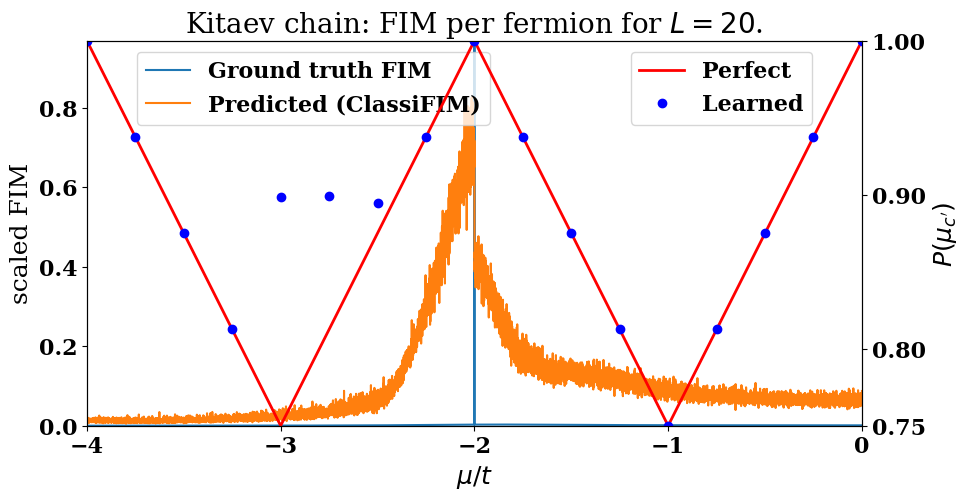

In [33]:
font = {'family' : 'serif', 'weight' : 'bold', 'size'   : 18}
matplotlib.rc('font', **font)

fig, ax1 = plt.subplots(figsize=(10, 5))

# Plotting the first plot
ax1.plot(gt_fim['lambda0'], scaled_fim_gs, label="Ground truth FIM")
ax1.plot(ml_mus, scaled_fim_hat, label="Predicted (ClassiFIM)")
ax1.set_xlim([-4, 0])
ax1.set_ylim([0, 1.1 * np.max(scaled_fim_hat)])
ax1.set_xlabel("$\mu/t$", fontsize=18)
ax1.set_ylabel("scaled FIM", fontsize=18)
ax1.tick_params(axis='both', labelsize=16)
ax1.set_title("Kitaev chain: FIM per fermion for $L=20$.", fontsize=20)

# Create a twin Axes sharing the xaxis
ax2 = ax1.twinx()

# Plotting the second plot
ax2.plot(w_perfect_x, w_perfect_y, '-r', lw=2, label="Perfect")
ax2.plot(w_learned_x, w_learned_y, 'bo', label="Learned")
ax2.set_ylabel('$P(\mu_{c\'})$', fontsize=18)  # Second y-axis label
ax2.set_ylim([0.75, 1.])
ax2.tick_params(axis='y', labelsize=16)

# Optionally, if you want to specify xticks for both plots, ensure they have the same xticks.
ax1.set_xticks([-4, -3, -2, -1, 0])
ax2.set_xticks([-4, -3, -2, -1, 0])
# ax1.set_yticks([0, 5, 10, 15])
ax2.set_yticks([0.75, 0.8, 0.9, 1.0])

# Optionally, adding legends if needed
ax1.legend(loc='upper left', fontsize=16, bbox_to_anchor=(0.05, 1), bbox_transform=ax1.transAxes)
ax2.legend(loc='upper right', fontsize=16, bbox_to_anchor=(0.95, 1), bbox_transform=ax2.transAxes)

filename = f"{DATA_DIR}/figs/kitaev20-w-fim-inset.png"
fig.savefig(filename, bbox_inches='tight', dpi=300)
print(f"Saved to {filename}")

### Test error

In [36]:
# This was just copied from kitaev20_classifim.ipynb
test_losses = {
    "42_0": 0.207101,
    "42_1": 0.209263,
    "42_2": 0.208541,
    "42_3": 0.208002,
    "42_4": 0.209265,
    "42_5": 0.209150,
    "42_6": 0.208227,
    "42_7": 0.209075,
    "42_8": 0.208390,
    "42_9": 0.209371}
print(classifim.bench.metric.normal_summary(np.array(list(test_losses.values()))))

0.2086 \pm 0.0007


### Compute dist metrics

* Requires:
    - Run "Load FIM" section above
* Produces: `metrics/dist_res.npz` with distSE values, distMSE & distRE metrics

In [40]:
METRICS_DIR = classifim.utils.maybe_create_subdir(DATA_DIR, "metrics")

In [207]:
importlib.reload(classifim.bench.metric)

<module 'classifim.bench.metric' from '/home/victor/Dropbox (Lidar group)/qc4ml_work/bs_chifc/classifim/src/classifim/bench/metric.py'>

In [213]:
start, stop, _ = PARAMETER_GRID[0]
coeff = stop - start
for v in ml_fims.values():
    assert np.allclose(
        [f(v["lambda0"]) for f in [np.min, np.max]],
        [0, 1])
    v["lambda0"] = start + coeff * v["lambda0"]
    v["fim_00"] = v["fim_00"] / coeff**2

In [214]:
%%time
for v in ml_fims.values():
    assert np.allclose(
        [f(v["lambda0"]) for f in [np.min, np.max]],
        PARAMETER_GRID[0][:2])
res = {}
def wrapper(seed):
    prng = classifim.utils.DeterministicPrng(seed)
    cur_res = classifim.bench.metric.compute_distance_errors_1d(
        PARAMETER_GRID, ml_fims[seed], gt_fim, num_pairs=8386560,
        seed=prng.get_seed("compute_distance_errors"),
        cpp_version="cpp1d")
    res[seed] = cur_res
    return seed
with concurrent.futures.ThreadPoolExecutor() as executor:
    r = list(executor.map(wrapper, list(ml_fims.keys())))

CPU times: user 6min 6s, sys: 21.7 s, total: 6min 28s
Wall time: 40.8 s


In [215]:
dist_res = {}
for key in next(iter(res.values())).keys():
    value = np.array([r[key] for r in res.values()])
    dist_res[key] = value
dist_res["ml_fim_seed"] = np.array(list(res.keys()))
DIST_RES_PATH = os.path.join(METRICS_DIR, "dist_res2.npz")
np.savez_compressed(DIST_RES_PATH, **dist_res)

### Print dist metrics

In [198]:
METRICS_DIR = os.path.join(DATA_DIR, "metrics")
dist_res_filename = os.path.join(METRICS_DIR, "dist_res2.npz")
# dist_res = np.load(dist_res_filename)
# df = {key: value for key, value in dist_res.items() if len(value.shape) == 1}
# df = pd.DataFrame(df)
# df.set_index("ml_fim_seed", inplace=True)
with np.load(dist_res_filename) as f:
    df = pd.DataFrame({
        key: value
        for key in f.keys()
        if key not in ["lambda_pairs", "distances"]
            and len((value := f[key]).shape) == 1
    })
df.set_index("ml_fim_seed", inplace=True)


display(df)

for column_name, values in df.items():
    digits = 4
    if 'distRE' in column_name:
        # digits = 2
        values = values * 100
        column_name = column_name + " (%)"
    elif column_name.startswith("num_"):
        digits = 0
    print(
        f"{column_name}: "
        f"${classifim.bench.metric.normal_summary(values, digits=digits)}$")

,num_pairs,distMSE,distRE,distMSE_const,distRE_const,distRE_perfect,distMSE_perfect_scale,space_dim,scale
ml_fim_seed,,,,,,,,,
42_6,8386560,5.425815,0.031153,1.687048,0.072064,0.000000e+00,0.705674,1,1.464218
42_7,8386560,5.322008,0.030722,1.687389,0.072067,1.421780e-14,0.672513,1,1.458913
42_1,8386560,5.476250,0.031391,1.686629,0.072028,0.000000e+00,0.715033,1,1.467049
42_9,8386560,5.439892,0.032524,1.688291,0.072126,1.421780e-14,0.727442,1,1.463684
42_2,8386560,5.349557,0.031325,1.686855,0.072028,0.000000e+00,0.711346,1,1.458276
42_4,8386560,5.704798,0.034320,1.688232,0.072047,0.000000e+00,0.756196,1,1.480774
42_8,8386560,5.443147,0.031614,1.687724,0.072034,1.421780e-14,0.711137,1,1.464975
42_0,8386560,5.216105,0.029515,1.686428,0.072011,0.000000e+00,0.680309,1,1.450636
42_3,8386560,5.225940,0.031465,1.687491,0.072088,0.000000e+00,0.706566,1,1.449979


num_pairs: $8386560 \pm 0$
distMSE: $5.4004 \pm 0.1325$
distRE (%): $3.1639 \pm 0.1194$
distMSE_const: $1.6873 \pm 0.0006$
distRE_const (%): $7.2054 \pm 0.0032$
distRE_perfect (%): $0.0000 \pm 0.0000$
distMSE_perfect_scale: $0.7105 \pm 0.0220$
space_dim: $1.0000 \pm 0.0000$
scale: $1.4620 \pm 0.0083$


In [216]:
METRICS_DIR = os.path.join(DATA_DIR, "metrics")
dist_res_filename = os.path.join(METRICS_DIR, "dist_res2.npz")
# dist_res = np.load(dist_res_filename)
# df = {key: value for key, value in dist_res.items() if len(value.shape) == 1}
# df = pd.DataFrame(df)
# df.set_index("ml_fim_seed", inplace=True)
with np.load(dist_res_filename) as f:
    df = pd.DataFrame({
        key: value
        for key in f.keys()
        if key not in ["lambda_pairs", "distances"]
            and len((value := f[key]).shape) == 1
    })
df.set_index("ml_fim_seed", inplace=True)


display(df)

for column_name, values in df.items():
    digits = 4
    if 'distRE' in column_name:
        # digits = 2
        values = values * 100
        column_name = column_name + " (%)"
    elif column_name.startswith("num_"):
        digits = 0
    print(
        f"{column_name}: "
        f"${classifim.bench.metric.normal_summary(values, digits=digits)}$")

,num_pairs,distMSE,distRE,distMSE_const,distRE_const,distRE_perfect,distMSE_perfect_scale,space_dim,scale
ml_fim_seed,,,,,,,,,
2,8386560,5.354982,0.031303,1.688067,0.072015,0.000000e+00,0.711667,1,1.458390
1,8386560,5.474879,0.031405,1.687508,0.072051,0.000000e+00,0.715668,1,1.467024
5,8386560,5.402128,0.032372,1.687295,0.072064,0.000000e+00,0.718994,1,1.461593
0,8386560,5.217359,0.029495,1.687097,0.072010,1.421780e-14,0.680412,1,1.450654
4,8386560,5.700680,0.034304,1.687169,0.072018,0.000000e+00,0.755748,1,1.480727
9,8386560,5.442998,0.032511,1.688234,0.072110,0.000000e+00,0.727238,1,1.463857
3,8386560,5.234597,0.031416,1.687332,0.072012,0.000000e+00,0.706210,1,1.450094
7,8386560,5.323157,0.030703,1.687467,0.072021,0.000000e+00,0.672551,1,1.458888
8,8386560,5.443395,0.031640,1.687485,0.072054,0.000000e+00,0.711375,1,1.464866


num_pairs: $8386560 \pm 0$
distMSE: $5.4022 \pm 0.1300$
distRE (%): $3.1630 \pm 0.1197$
distMSE_const: $1.6875 \pm 0.0003$
distRE_const (%): $7.2039 \pm 0.0030$
distRE_perfect (%): $0.0000 \pm 0.0000$
distMSE_perfect_scale: $0.7106 \pm 0.0219$
space_dim: $1.0000 \pm 0.0000$
scale: $1.4620 \pm 0.0083$


### Best possible cross entropy error

* Requires:
    - Ground state probabilities in 'lanczos' dir
    - Test dumps (produced by `kitaev20_classifim.ipynb`) at `classifim_datasets/test_dump_{seed}.npz`.
* Prints out best possible cross entropy error (for an algorithm which knows ground state probabilities).

In [ ]:
%%time
DATASETS_DIR = os.path.join(DATA_DIR, "classifim_datasets")
assert os.path.isdir(DATASETS_DIR)
best_xes = {}
for seed in range(42, 52):
    res = classifim_bench.fil24_hamiltonian.compute_best_possible_xe(
        dump_npz=np.load(os.path.join(DATASETS_DIR, f"test_dump_{seed}.npz")),
        zs_to_vi_f=lambda zs: ham_family.z_to_vi[ham_family.unrepack_z_for_bschifc(zs)],
        lambdas_to_params_f=param_conversions.lambdas_to_params,
        probs_cache=get_lanczos_cache(),
        resolution=64)
    best_xes[seed] = res

In [ ]:
v = np.array(list(best_xes.values()))
summary = classifim.bench.metric.normal_summary(v)
print(f"Best possible XE: {summary}")